In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import time
import os

In [2]:
data_dir = './FACE_MASK'

In [4]:
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
validation_transforms = transforms.Compose(transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir+'/Train',transform=train_transforms)
test_data = datasets.ImageFolder(data_dir+'/Test',transform=test_transforms)
val_data = datasets.ImageFolder(data_dir+'/Validation', transform=validation_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64,shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

In [5]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [6]:
def createDirectory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        print("Directory " + dirname + " already exists.")

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

In [9]:
models_dir = "maskModels/"
createDirectory(models_dir)
epochs = 20
steps = 0
running_loss = 0
training_losses = []
test_losses = []
for epoch in range(epochs):
    running_loss = 0
    
    for inputs, labels in trainloader:
        steps += 1
        
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        start = time.time()
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

    running_loss += loss.item()
    training_losses.append(running_loss)
    test_loss = 0
    accuracy = 0
    model.eval()
        
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
            test_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    print(f"Epoch {epoch+1} "
          f"Train loss: {running_loss:.3f}.. "
          f"Test loss: {test_loss/len(testloader):.3f}.. "
          f"Test accuracy: {accuracy/len(testloader):.3f}")
    
    test_losses.append(test_loss)
    if min(test_losses) == test_losses[-1]:
        best_epoch = epoch
        checkpoint = {'model': model,
                            'state_dict': model.state_dict(),
                            'optimizer' : optimizer.state_dict()}
        torch.save(checkpoint, models_dir + '{}.pth'.format(epoch))
        print("Model saved")
    model.train()
print(f"Time per batch: {(time.time()-start)/3:.3f} seconds")

Directory maskModels/ already exists.
Epoch 1 Train loss: 0.026.. Test loss: 0.159.. Test accuracy: 0.936
Model saved
Epoch 2 Train loss: 0.012.. Test loss: 0.151.. Test accuracy: 0.944
Model saved
Epoch 3 Train loss: 0.032.. Test loss: 0.247.. Test accuracy: 0.916
Epoch 4 Train loss: 0.100.. Test loss: 0.104.. Test accuracy: 0.964
Model saved
Epoch 5 Train loss: 0.090.. Test loss: 0.118.. Test accuracy: 0.958
Epoch 6 Train loss: 0.087.. Test loss: 0.144.. Test accuracy: 0.942
Epoch 7 Train loss: 0.679.. Test loss: 0.119.. Test accuracy: 0.950
Epoch 8 Train loss: 0.064.. Test loss: 0.270.. Test accuracy: 0.899
Epoch 9 Train loss: 0.072.. Test loss: 0.100.. Test accuracy: 0.966
Model saved
Epoch 10 Train loss: 0.177.. Test loss: 0.161.. Test accuracy: 0.938
Epoch 11 Train loss: 0.266.. Test loss: 0.107.. Test accuracy: 0.959
Epoch 12 Train loss: 0.012.. Test loss: 0.246.. Test accuracy: 0.924
Epoch 13 Train loss: 0.206.. Test loss: 0.147.. Test accuracy: 0.943
Epoch 14 Train loss: 0.248

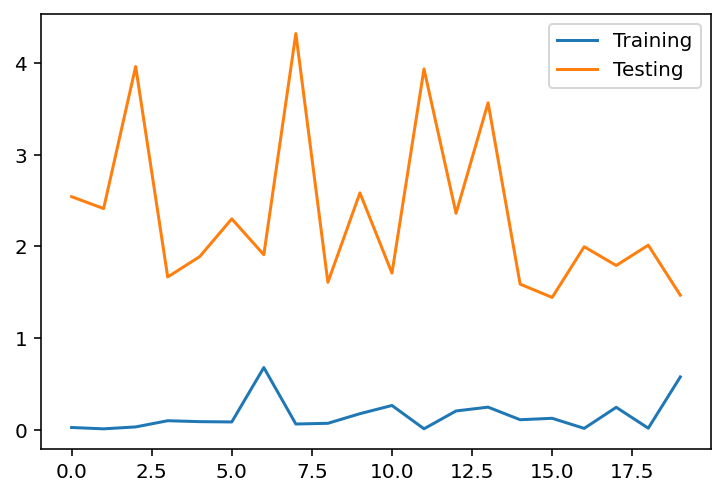

In [11]:
plt.plot(range(epochs), training_losses, label='Training')
plt.plot(range(epochs), test_losses, label='Testing')
plt.legend()

In [12]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()

models_dir = "maskModels/"
filepath = models_dir + str(best_epoch) + ".pth"
# filepath = models_dir + str(6) + ".pth"
loaded_model = load_checkpoint(filepath)
print(filepath)

train_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

maskModels/15.pth


In [14]:
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import argparse
import numpy as np
import cv2

root_path = './'
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-f", "--face", type=str,
    default="face_detector",
    help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
    default="mask_detector.model",
    help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
    help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

prototxtPath = root_path + 'face_detector/deploy.prototxt'
weightsPath = root_path + 'face_detector/res10_300x300_ssd_iter_140000.caffemodel'
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

print("[INFO] starting video stream...")

cap = cv2.VideoCapture(1)

font_scale=1
thickness = 2
red = (0,0,255)
green = (0,255,0)
blue = (255,0,0)
font=cv2.FONT_HERSHEY_SIMPLEX

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame = cv2.flip(frame,1)
        (h, w) = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
            (104.0, 177.0, 123.0))

        # pass the blob through the network and obtain the face detections
        faceNet.setInput(blob)
        detections = faceNet.forward()

        # initialize our list of faces, their corresponding locations,
        # and the list of predictions from our face mask network
        faces = []
        locs = []
        preds = []
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
            confidence = detections[0, 0, i, 2]

            # filter out weak detections by ensuring the confidence is
            # greater than the minimum confidence
            if confidence > args["confidence"]:
                # compute the (x, y)-coordinates of the bounding box for
                # the object
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                # ensure the bounding boxes fall within the dimensions of
                # the frame
                (startX, startY) = (max(0, startX), max(0, startY))
                (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

                # extract the face ROI, convert it from BGR to RGB channel
                # ordering, resize it to 224x224, and preprocess it
                face = frame[startY:endY, startX:endX]
                face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                face = cv2.resize(face, (224, 224))
                face = img_to_array(face)
                face = preprocess_input(face)

                # add the face and bounding boxes to their respective
                # lists
                faces.append(face)
                locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
        if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
            faces = np.array(faces, dtype="float32")
            
            

            for (startX, startY, endX, endY) in locs:
            
                croped_img = frame[startY:endY, startX:endX]
                pil_image = Image.fromarray(croped_img, mode = "RGB")
                pil_image = train_transforms(pil_image)
                image = pil_image.unsqueeze(0)
                image = image.to(device)

                result = loaded_model(image)
                _, maximum = torch.max(result.data, 1)
                prediction = maximum.item()

            
                if prediction == 0:
                    cv2.putText(frame, "Mask Verified", (startX,startY - 10), font, font_scale, green, thickness)
                    cv2.rectangle(frame, (startX, startY), (endX, endY), green, 2)
                elif prediction == 1:
                    cv2.putText(frame, "Please wear a mask", (startX,startY - 10), font, font_scale, red, thickness)
                    cv2.rectangle(frame, (startX, startY), (endX, endY), red, 2)
        cv2.imshow('frame',frame)
        
        if (cv2.waitKey(1) & 0xFF) == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()

[INFO] starting video stream...
